### Enter the central coordinates of an area of interest (10km x 10km) in cell below, e.g.:
x,y = 150.7264,-33.6152

In [1]:
x,y = 150.7264,-33.6152

### To produce LFMC maps for all available, good quality Sentinel-2 satellite data in the last month, in the above dropdown menu 'Run', click 'Run All Cells'
Running may take a few minutes, a message of success will appear at bottom when mapping is complete. Maps are saved as .tif files.

In [3]:
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
import datetime
# import pickle#5 as pickle
import joblib
import time
import os
import argparse
import sklearn_xarray
import dask.distributed
from pystac_client import Client
from odc.stac import configure_rio, stac_load

def map_compute_fmc(x_lat, y_lon):
    """
    Given central coordinates x, y, predict forest LFMC for 10 km square around coordinates.
    """
    # Create bounding box
    # x_lat, y_lon = (150.72646076028656,-33.61529216202892)  # Example coordinates / center point of a query
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3308')
    x,y = transformer.transform(y_lon,x_lat)
    edge_area = 10000 # edge of the square area of interest around center point in m
    # km2deg = 1.0 / 111
    # r = edge_area * km2deg
    # bbox = (x - r, y - r, x + r, y + r)
    
    # Load mask of vegetation/tree cover (Albers/20m projection, 3308), clip to bounding box pixels
    trees = xr.open_dataset(f'data/nonveg_mask_nve_nsw_v2.tif', 
                chunks='auto').band_data.drop_vars('band').squeeze('band')
    trees = trees.chunk('auto')
    trees.attrs = {}
    # trees = trees.rio.clip_box(*bbox, crs='EPSG:4326')
    trees = trees.sel(x=slice(x-(edge_area/2), x+(edge_area/2)),
                      y=slice(y+(edge_area/2), y-(edge_area/2)))
    # rio.clip_box(*bbox, crs='EPSG:4326')
                      
    # Create date range for 30 days till today
    today = str(datetime.date.today())
    month_ago = str(datetime.date.today() - datetime.timedelta(days=30))
    
    # Create dask client
    client = dask.distributed.Client()
    configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
    
    # Query STAC for reflectance data
    catalog = Client.open("https://explorer.dea.ga.gov.au/stac")
    query = catalog.search(
        collections=["ga_s2am_ard_3","ga_s2bm_ard_3","ga_s2cm_ard_3"], 
        datetime=(month_ago,today), bbox=trees.rio.transform_bounds('EPSG:4326')
    )
    items = list(query.items())
    
    # Define bands of Sentinel-2 reflectance to retrieve
    s2_bands = ['nbart_red','nbart_green','nbart_blue','nbart_red_edge_1','nbart_red_edge_2',
             'nbart_red_edge_3','nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']
    
    # Load data and apply fmask keeping only good (==1) data
    s2_cube = stac_load(
        items,
        bands=s2_bands+['oa_fmask'],
        # crs='epsg:3308',
        # resolution=20,
        # chunks={},  # <-- use Dask
        chunks = {'time':1},
        groupby="solar_day",
        cloud_mask='fmask',
        like=trees
    )
    s2_cube = s2_cube.where(s2_cube['oa_fmask']==1)
    s2_cube = s2_cube.drop_vars('oa_fmask')
    s2_cube = s2_cube.dropna(dim='time', how='all')
    s2_cube.load()
    
    # Add NDVI and NDII
    s2_cube['ndii'] = ((s2_cube.nbart_nir_1-s2_cube.nbart_swir_2)/(s2_cube.nbart_nir_1+s2_cube.nbart_swir_2))
    s2_cube['ndvi'] = ((s2_cube.nbart_nir_1-s2_cube.nbart_red)/(s2_cube.nbart_nir_1+s2_cube.nbart_red))
    s2_cube.time.attrs = {}
    
    # Load the trained random forest model from disk
    # with open('rf_xr_s2fmc_forest.pickle', 'rb') as handle:
    #     rf = pickle.load(handle)
    rf = joblib.load('rf_s2fmc_forest.joblib')
    rf_predictors = ['ndvi','ndii']+s2_bands
    # rf.set_params(n_jobs=-1)
    # rf.set_params(reshapes='variable')
    
    print('Data prepared. Starting LFMC prediction...')
    
    # Encoding for writing netcdf
    encoding = {'foliar_moisture_content':{'zlib': True, "complevel": 1, 'shuffle': True}}
    x_,y_ = str(x).replace('.','_'), str(y).replace('.','_')
    # Clear output location
    folder_path = 'outputs/'
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
    
    # Run random forest emulator of RTM model of LFMC on each timestep of dataset
    for t in s2_cube.time.data[:]:
        t0 = time.time()
        data = s2_cube.sel(time=t) # selects timestep
        if not np.isnan(data).all().compute():
            s2_cube = s2_cube.drop_sel(time=t) # drop the empty timestep from ds
            continue # Continues to next if timepoint all nan (i.e. no good data)
        
        # Data transformation if using xarray/xarray-sklearn/dask
        # data = data.chunk('auto') # sets the chunksize of the array to be spread across dask workers
        # data = data[rf_predictors].to_array().stack(index=['y','x']).transpose() # reshapes the dataset to an array to suit random forest
        # data = data.where(np.isfinite(data), 0) # sets all nan kind of data to 0 to suit random forest
        
        # Data transformation if using pandas/sklearn (i.e. in memory)
        data = data[rf.feature_names_in_].drop(['spatial_ref','time']).to_dataframe()
        
        try:
            data = rf.predict(data.values) # runs random forest
        except Exception as error:
            print('Continuing to next timestep because of error:',error)
            continue # in case of the rasterio error retrieving fmask
        
        # data = data.unstack(dim=['index']) # reverses the reshaping back to 2 dimensions (x and y)
        
        data = xr.DataArray(data.reshape(len(s2_cube.x),len(s2_cube.y)), 
                 coords=s2_cube.sel(time=t).coords).expand_dims('time')
        
        data = data.where(np.isfinite(s2_cube.sel(time=t)['ndii'])) # reverses the setting of 0 to nan; applies mask from reflectance data
        data = data.where(trees) # masks pixels which are not tree cover
    #     data = data.assign_coords({'time':t,'spatial_ref':s2_cube.spatial_ref}).expand_dims('time')
        # assign the time dimension back to array
        data = data.rename('foliar_moisture_content')
    
        # Write out a tif of the timestep
        t_ = str(t)[:10] 
        data.rio.to_raster(f'outputs/lfmc_{x_}_{y_}_{t_}.tif', encoding=encoding)
    
        # Add time dimension to array and merge array back to s2_cube
        # data['time'] = t
        # data = data.expand_dims('time')
        s2_cube = s2_cube.merge(data.compute())
    
    s2_cube['foliar_moisture_content'].attrs['units'] = '% dry weight'
    g = s2_cube['foliar_moisture_content'].plot(col='time',col_wrap=3,robust=True)
    g.fig.suptitle('LFMC of tree cover in area of interest')
    plt.show()
    
    # Average LFMC across time and save out
    s2_cube['mean_fmc'] = s2_cube['foliar_moisture_content'].mean('time')
    s2_cube['mean_fmc'].rio.to_raster(f'outputs/lfmc_{x_}_{y_}_mean_{month_ago}_to_{today}.tif',
                                     encoding=encoding)
    
    print('\nSuccess! LFMC maps written to outputs/ folder including a mean across available dates. Download files from the outputs/ folder in the file browser to the right.')

    return


/opt/miniconda3/envs/lfmc_maps_env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63921 instead
  warnings.warn(
/opt/miniconda3/envs/lfmc_maps_env/lib/python3.9/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/opt/miniconda3/envs/lfmc_maps_env/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/miniconda3/envs/lfmc_maps_env/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpic

Data prepared. Starting LFMC prediction...


/var/folders/5w/l8101x4x68s1wvkmgbtgklh80000gp/T/ipykernel_89895/1009052142.py:116: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data = data[rf.feature_names_in_].drop(['spatial_ref','time']).to_dataframe()
/opt/miniconda3/envs/lfmc_maps_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/var/folders/5w/l8101x4x68s1wvkmgbtgklh80000gp/T/ipykernel_89895/1009052142.py:116: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data = data[rf.feature_names_in_].drop(['spatial_ref','time']).to_dataframe()
/opt/miniconda3/envs/lfmc_maps_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


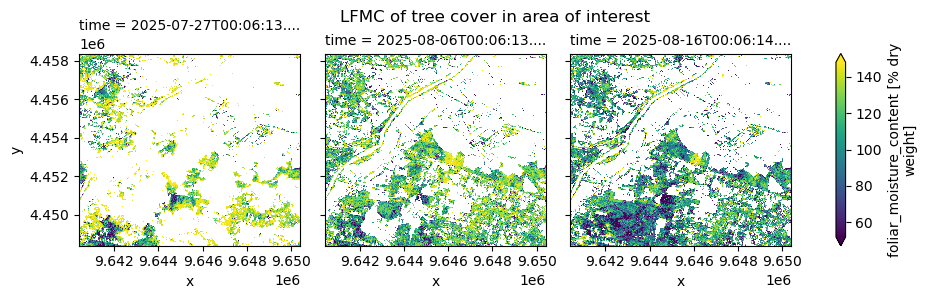


Success! LFMC maps written to outputs/ folder including a mean across available dates. Download from the outputs/ folder in the file browser to the right.


In [5]:
map_compute_fmc(x,y)